[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/main)

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, ".")
sys.path.insert(0, "..")

# Plotting preferences
from cycler import cycler
from matplotlib import rcParams

%matplotlib inline

LIGHT_COLORMAP = [
    (0.533, 0.741, 0.902),
    (0.984, 0.698, 0.345),
    (0.565, 0.804, 0.592),
    (0.965, 0.667, 0.788),
    (0.749, 0.647, 0.329),
    (0.737, 0.6, 0.78),
    (0.929, 0.867, 0.275),
    (0.941, 0.494, 0.431),
    (0.549, 0.549, 0.549),
]

# Plotting preferences
plt.rc("axes", prop_cycle=cycler("color", LIGHT_COLORMAP))
plt.rc("figure", figsize=(12, 6))
#rcParams.update({"figure.figsize": (12, 6)})
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

In [3]:
from pipelines.gridwatch import load_file

df_plants = load_file("plants.csv", "raw", source="local")
df_capability = load_file("capability.csv", source="local")
df_output = load_file("output.csv", source="local")
df_summary = load_file("summary.csv", source="local")

df_summary.head()

,Imports (MW),Exports (MW),Net Import/Exports (MW),Power Generated (MW),Ontario Demand (MW),Total Emissions (tonnes),CO2e Intensity (g/kWh),nuclear (%),hydro (%),gas (%),wind (%),biofuel (%),solar (%),nuclear (MW),hydro (MW),gas (MW),wind (MW),biofuel (MW),solar (MW)
2021-10-14 08:00:00,1216.0,1565.0,349.0,15435.0,15086.0,769.0,50.0,54.7,23.3,14.8,6.7,0.2,0.3,8445.0,3594.0,2291.0,1033.0,31.0,41.0
2021-10-14 09:00:00,1239.0,1513.0,274.0,15536.0,15262.0,759.0,49.0,54.4,24.6,14.9,5.3,0.2,0.6,8444.0,3820.0,2308.0,826.0,38.0,100.0
2021-10-14 10:00:00,1105.0,1523.0,418.0,15824.0,15406.0,970.0,61.0,53.4,23.0,17.8,4.2,0.3,1.3,8445.0,3647.0,2820.0,665.0,47.0,200.0
2021-10-14 11:00:00,920.0,1711.0,791.0,16361.0,15570.0,1024.0,63.0,51.6,23.8,19.2,3.7,0.3,1.3,8447.0,3900.0,3144.0,605.0,47.0,218.0
2021-10-14 12:00:00,919.0,1458.0,539.0,16222.0,15683.0,1042.0,64.0,52.1,23.5,19.3,3.4,0.3,1.4,8457.0,3817.0,3128.0,551.0,43.0,226.0


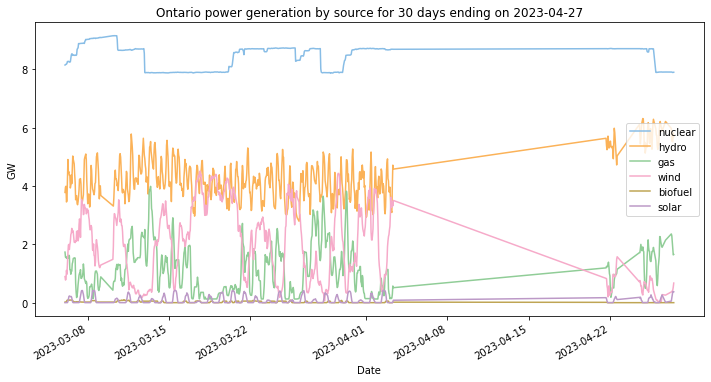

In [4]:
output_types = [col.replace(' (%)', '') for col in df_summary.columns if col.endswith(' (%)')]
output_cols = [f"{col} (MW)" for col in output_types]
(df_summary[output_cols].iloc[-30*24:] / 1e3).plot()
plt.ylabel('GW')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source for 30 days ending on {df_summary.index[-1].date().isoformat()}')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source_30_day.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

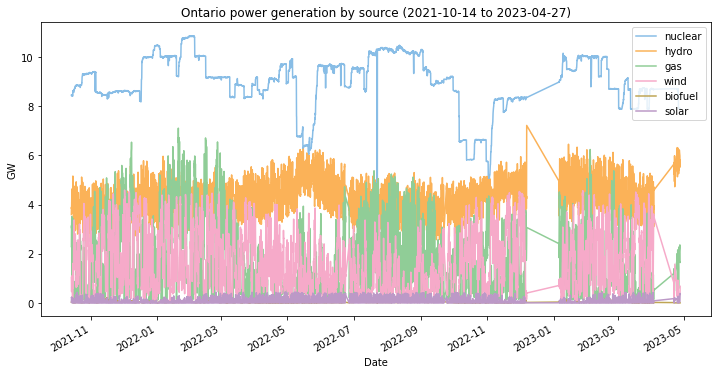

In [5]:
(df_summary[output_cols] / 1e3).plot()
plt.ylabel('GW')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

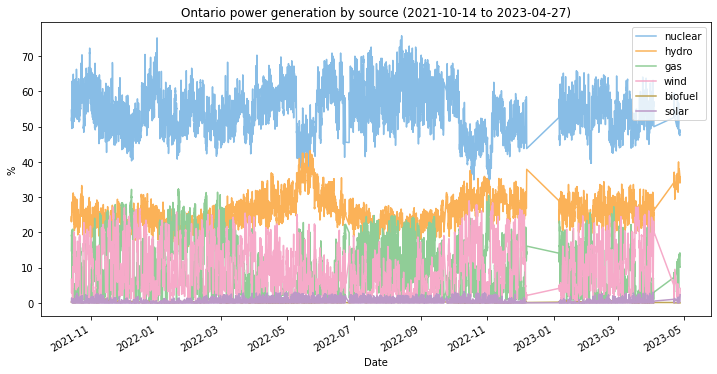

In [6]:
percentage_cols = [f"{col} (%)" for col in output_types]

df_summary[percentage_cols].plot()
plt.ylabel('%')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (%)', '') for col in percentage_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source_percentage.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

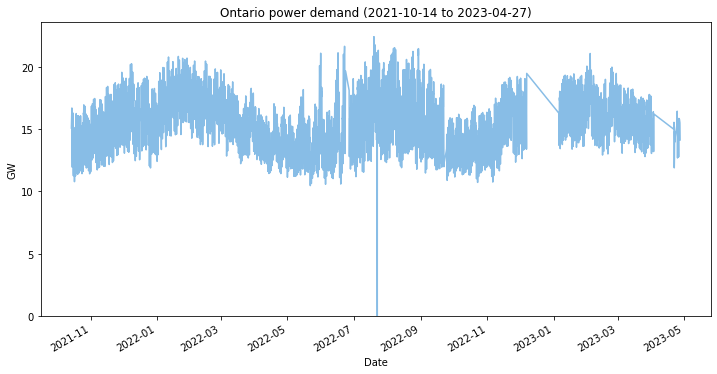

In [7]:
(df_summary['Ontario Demand (MW)'] / 1e3).plot()
plt.ylabel('GW')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'Ontario power demand ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.savefig(
    os.path.join("..", "images", "ontario_power_demand.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

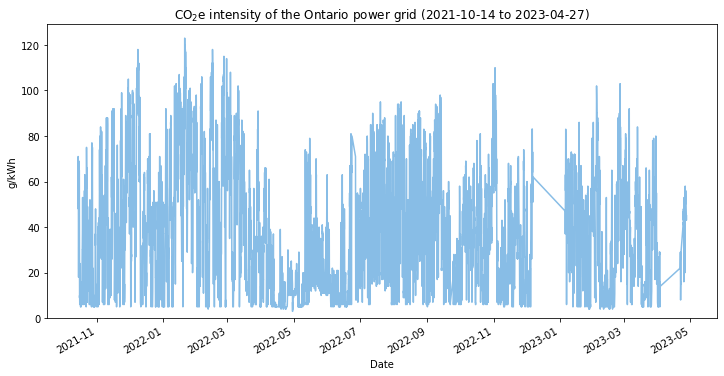

In [8]:
df_summary['CO2e Intensity (g/kWh)'].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'CO$_2$e intensity of the Ontario power grid ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.savefig(
    os.path.join("..", "images", "ontario_co2_intensity.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

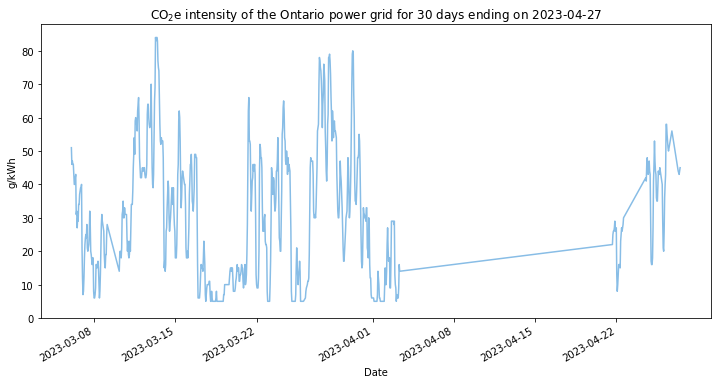

In [9]:
df_summary['CO2e Intensity (g/kWh)'].iloc[-24*30:].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'CO$_2$e intensity of the Ontario power grid for 30 days ending on {df_summary.index[-1].date().isoformat()}')
plt.savefig(
    os.path.join("..", "images", "ontario_co2_intensity_30_day.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

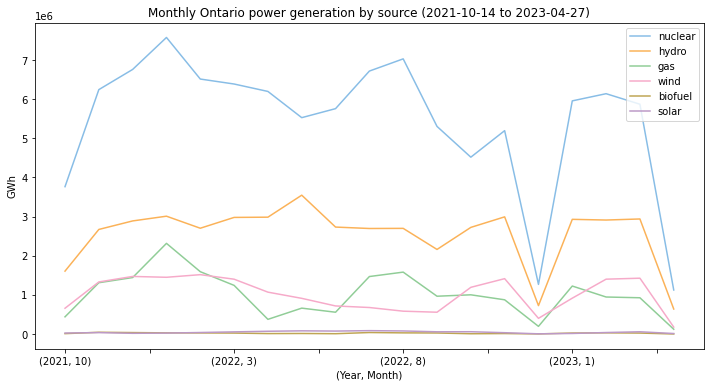

In [52]:
df_summary["month"] = df_summary.index.month
df_summary["year"] = df_summary.index.year
df_summary.groupby(["year", "month"]).sum()[output_cols].plot()
plt.ylabel('GWh')
plt.xlabel('(Year, Month)')
plt.title(f'Monthly Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source_monthly.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

In [147]:
df_gridwatch = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/gridwatch.ca/hourly/summary.csv", index_col=0)
df_gridwatch.index = pd.to_datetime(df_gridwatch.index).tz_localize(-5*60*60).tz_convert("America/Toronto")
df_gridwatch.tail()

,Imports (MW),Exports (MW),Net Import/Exports (MW),Power Generated (MW),Ontario Demand (MW),Total Emissions (tonnes),CO2e Intensity (g/kWh),nuclear (%),hydro (%),gas (%),wind (%),biofuel (%),solar (%),nuclear (MW),hydro (MW),gas (MW),wind (MW),biofuel (MW),solar (MW)
2023-04-28 12:00:00-04:00,33.0,2330.0,2297.0,17071.0,14774.0,630.0,37.0,46.3,34.8,8.5,9.0,0.0,1.4,7896.0,5937.0,1452.0,1543.0,0.0,243.0
2023-04-28 13:00:00-04:00,133.0,1972.0,1839.0,16538.0,14699.0,485.0,29.0,47.8,33.6,7.0,10.3,0.0,1.3,7897.0,5560.0,1153.0,1708.0,0.0,220.0
2023-04-28 14:00:00-04:00,252.0,2127.0,1875.0,16658.0,14783.0,412.0,25.0,47.4,33.3,5.9,12.2,0.0,1.2,7899.0,5550.0,981.0,2031.0,0.0,197.0
2023-04-28 15:00:00-04:00,11.0,2135.0,2124.0,16795.0,14671.0,465.0,28.0,47.0,31.3,6.6,13.9,0.0,1.2,7902.0,5250.0,1108.0,2336.0,0.0,199.0
2023-04-28 16:00:00-04:00,9.0,2126.0,2117.0,16775.0,14658.0,384.0,23.0,47.1,30.6,5.3,15.9,0.0,1.1,7903.0,5140.0,883.0,2669.0,0.0,180.0


In [139]:
df_co2signal = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/co2signal.com/CA-ON/hourly/output.csv", index_col=0)
df_co2signal.index = pd.to_datetime(df_co2signal.index).tz_convert("America/Toronto")
df_co2signal.head()

,status,countryCode,data.carbonIntensity,data.fossilFuelPercentage,units.carbonIntensity
data.datetime,,,,,
2023-04-28 16:00:00-04:00,ok,CA-ON,43,6.40,gCO2eq/kWh
2023-04-28 15:00:00-04:00,ok,CA-ON,46,6.91,gCO2eq/kWh
2023-04-28 14:00:00-04:00,ok,CA-ON,52,8.04,gCO2eq/kWh
2023-04-28 13:00:00-04:00,ok,CA-ON,54,8.51,gCO2eq/kWh
2023-04-28 12:00:00-04:00,ok,CA-ON,56,8.92,gCO2eq/kWh


<AxesSubplot:xlabel='data.datetime'>

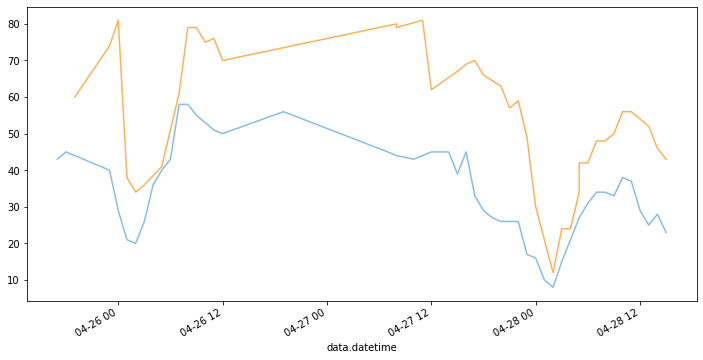

In [134]:
df_gridwatch.iloc[-24*2:]["CO2e Intensity (g/kWh)"].tz_localize(-5*60*60).plot()
df_co2signal.iloc[-24*2:]["data.carbonIntensity"].tz_convert(-5*60*60).plot()

In [125]:
import json
import requests

response = requests.get("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/ieso.ca/latest/output.json")
latest = json.loads(response.content.decode("utf-8"))
print(latest["datetime"], "(ieso) ->\t\t", latest["datetime"])
print(df_co2signal.sort_index().index[-1], "(co2signal) ->\t", df_co2signal.sort_index().index[-1].tz_convert("America/Toronto"))
print(df_gridwatch.sort_index().index[-1], "(gridwatch) ->\t\t", df_gridwatch.sort_index().index[-1].tz_localize(-5*60*60))


2023-04-28T15:00:00-05:00 (ieso) ->		 2023-04-28T15:00:00-05:00
2023-04-28 20:00:00+00:00 (co2signal) ->	 2023-04-28 16:00:00-04:00
2023-04-28 15:00:00 (gridwatch) ->		 2023-04-28 15:00:00-05:00


In [88]:
dti = pd.date_range(start='2023-03-12 00:00',
                    freq='H', periods=3, tz='America/Toronto')
dti

DatetimeIndex(['2023-03-12 00:00:00-05:00', '2023-03-12 01:00:00-05:00',
               '2023-03-12 03:00:00-04:00'],
              dtype='datetime64[ns, America/Toronto]', freq='H')

In [77]:
dti.tz_convert("UTC")

DatetimeIndex(['2023-03-12 05:00:00+00:00', '2023-03-12 06:00:00+00:00',
               '2023-03-12 07:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')

In [79]:
dti = pd.date_range(start='2023-03-12 00:00',
                    freq='H', periods=12, tz='UTC')
dti

DatetimeIndex(['2023-03-12 00:00:00+00:00', '2023-03-12 01:00:00+00:00',
               '2023-03-12 02:00:00+00:00', '2023-03-12 03:00:00+00:00',
               '2023-03-12 04:00:00+00:00', '2023-03-12 05:00:00+00:00',
               '2023-03-12 06:00:00+00:00', '2023-03-12 07:00:00+00:00',
               '2023-03-12 08:00:00+00:00', '2023-03-12 09:00:00+00:00',
               '2023-03-12 10:00:00+00:00', '2023-03-12 11:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')

In [80]:
dti.tz_convert(tz="America/Toronto")

DatetimeIndex(['2023-03-11 19:00:00-05:00', '2023-03-11 20:00:00-05:00',
               '2023-03-11 21:00:00-05:00', '2023-03-11 22:00:00-05:00',
               '2023-03-11 23:00:00-05:00', '2023-03-12 00:00:00-05:00',
               '2023-03-12 01:00:00-05:00', '2023-03-12 03:00:00-04:00',
               '2023-03-12 04:00:00-04:00', '2023-03-12 05:00:00-04:00',
               '2023-03-12 06:00:00-04:00', '2023-03-12 07:00:00-04:00'],
              dtype='datetime64[ns, America/Toronto]', freq='H')